### Problem Statement
A global call center corporation seeks to elevate customer experience and satisfaction by deploying a real-time emotion detection system for customer interactions. With a substantial daily influx of customer calls, accurately gauging the emotional states of customers becomes pivotal in delivering personalized and empathetic responses. The current manual monitoring process is not only time-intensive but also susceptible to errors.

### Objectives
1.	To develop an end-to-end Speech Emotion Recognition system using machine learning techniques to automatically detect and classify the emotional states of customers during phone calls. The system should be capable of analyzing speech signals in real time and categorizing emotions such as happiness, sadness, anger, and neutrality with high accuracy.
2. To improve the quality of customer-agent interactions by providing agents with timely insights into customers' emotional states, fostering better communication and rapport during calls.
3.	To enhance the company's reputation for customer-centricity by leveraging advanced emotion detection technology to offer tailored solutions and support based on the emotional needs of individual customers.

### Data Understanding

The data contains a collection of 200 target words spoken within the carrier phrase "Say the word _" by two actresses, aged 26 and 64 years. The recordings were captured for each of the seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral), resulting in a total of 2800 data points (audio files).



In [27]:
# Loading the necessary libraries

import os
import pandas as pd
import uuid
import librosa
import numpy as np


### Loading Data

In [28]:
#creating a DataFrame with additional information such as unique IDs and file paths
# Extracting emotions and placing it in its column

def extract_emotion(file_name):
    parts = file_name.split('_')
    emotion = parts[-1].split('.')[0]
    return emotion

def create_emotional_dataframe(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        emotion = extract_emotion(file_name)
        unique_id = f"{emotion}_{str(uuid.uuid4())[:8]}"
        file_path = os.path.join(folder_path, file_name)
        data.append({'ID': unique_id, 'File Name': file_name, 'Emotion': emotion, 'File Path': file_path})
        
    return pd.DataFrame(data)

folder_path_wav = r'dataverse_files'

emotion_df_wav = create_emotional_dataframe(folder_path_wav)

# Display the DataFrame
emotion_df_wav.head(10)

,ID,File Name,Emotion,File Path
0,angry_693c0b77,OAF_back_angry.wav,angry,dataverse_files\OAF_back_angry.wav
1,disgust_b9f2e115,OAF_back_disgust.wav,disgust,dataverse_files\OAF_back_disgust.wav
2,fear_a7d34d00,OAF_back_fear.wav,fear,dataverse_files\OAF_back_fear.wav
3,happy_5820924d,OAF_back_happy.wav,happy,dataverse_files\OAF_back_happy.wav
4,neutral_753bdcf1,OAF_back_neutral.wav,neutral,dataverse_files\OAF_back_neutral.wav
5,ps_6e9d4ea5,OAF_back_ps.wav,ps,dataverse_files\OAF_back_ps.wav
6,sad_fd4be1af,OAF_back_sad.wav,sad,dataverse_files\OAF_back_sad.wav
7,angry_309a4d59,OAF_bar_angry.wav,angry,dataverse_files\OAF_bar_angry.wav
8,disgust_d1c4fca7,OAF_bar_disgust.wav,disgust,dataverse_files\OAF_bar_disgust.wav
9,fear_b2d75d75,OAF_bar_fear.wav,fear,dataverse_files\OAF_bar_fear.wav


In [29]:
# Show the shape of the DataFrame
print("Shape of the DataFrame:", emotion_df_wav.shape)

# Show the columns of the DataFrame
print("\nColumns of the DataFrame:")
print(emotion_df_wav.columns)

# Display information about the DataFrame
print("\nInfo about the DataFrame:")
print(emotion_df_wav.info())


Shape of the DataFrame: (2800, 4)

Columns of the DataFrame:
Index(['ID', 'File Name', 'Emotion', 'File Path'], dtype='object')

Info about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         2800 non-null   object
 1   File Name  2800 non-null   object
 2   Emotion    2800 non-null   object
 3   File Path  2800 non-null   object
dtypes: object(4)
memory usage: 87.6+ KB
None


In [30]:
# Checking for null values in the DataFrame
null_values = emotion_df_wav.isnull().sum()

# Display columns with null values (if any)
columns_with_null = null_values[null_values > 0]
if not columns_with_null.empty:
    print("Columns with Null Values:")
    print(columns_with_null)
else:
    print("No Null Values in the DataFrame")

# Check for duplicated rows in the DataFrame
duplicated_rows = emotion_df_wav.duplicated()

# Display rows with duplicated values (if any)
if duplicated_rows.any():
    print("\nDuplicated Rows:")
    print(emotion_df_wav[duplicated_rows])
else:
    print("\nNo Duplicated Rows in the DataFrame")


No Null Values in the DataFrame

No Duplicated Rows in the DataFrame


### Exploratory Data Analysis

We will first plot the count of each emotion in our dataset.

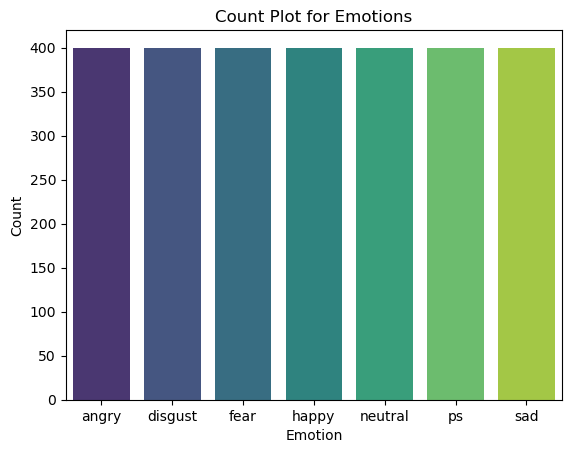

In [31]:
#lmporting the visualization libraries.
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=emotion_df_wav, x='Emotion', palette='viridis')
plt.title('Count Plot for Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


We will also plot:
waveplots which are visual representations of the audio signals and the spectograms which display the frequency content of audio signals as they vary over time.

**Waveplot and Spectrogram: Fear Emotion**

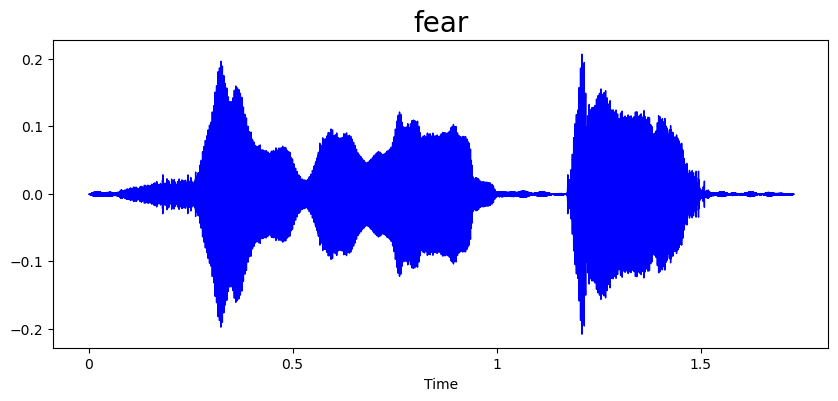

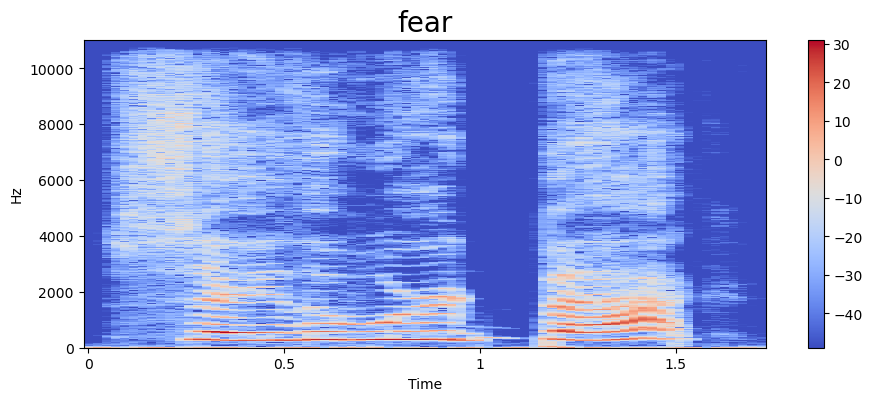

In [32]:

from IPython.display import Audio

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color='b')  # Set the color explicitly
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

# Assuming emotion_df_wav is your DataFrame
emotion = 'fear'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]  

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


**Waveplot and Spectrogram: Sad Emotion**

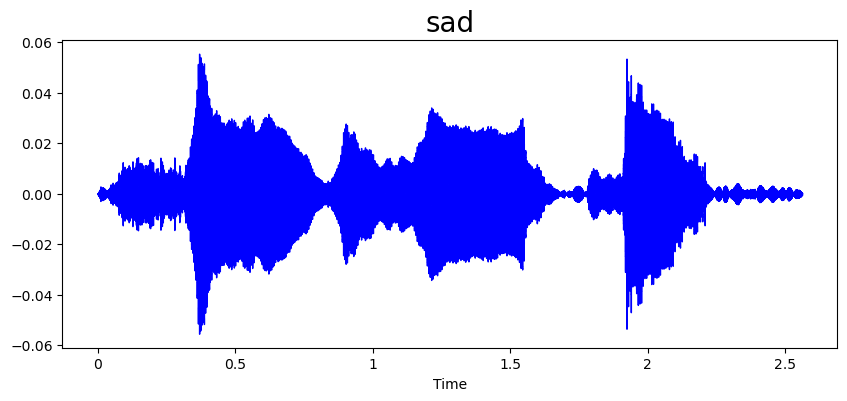

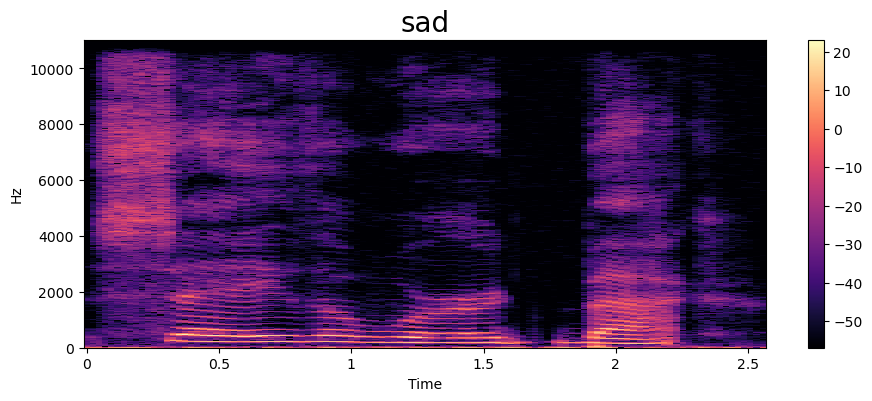

In [33]:
emotion = 'sad'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


**Waveplot and Spectrogram: Happy Emotion**

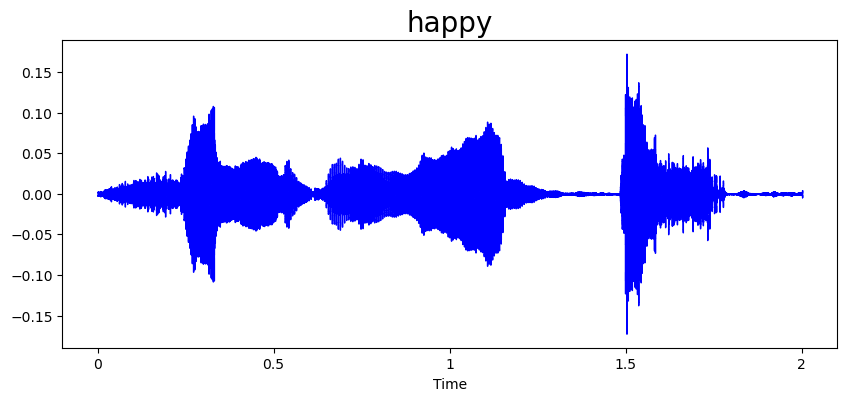

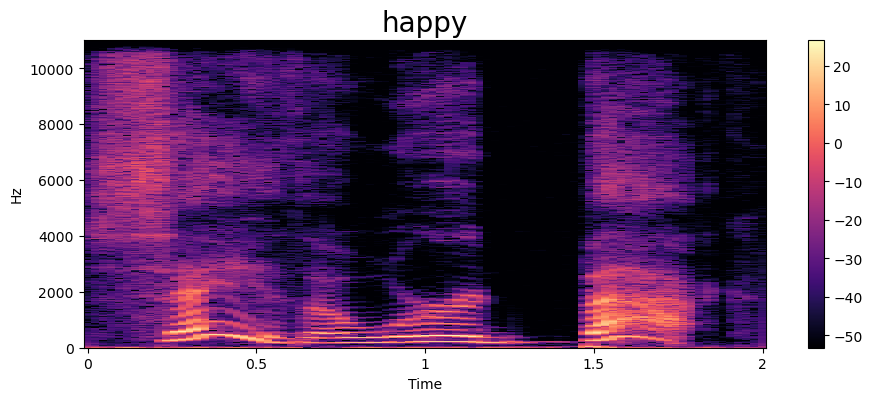

In [34]:
emotion = 'happy'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]  

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


**Waveplot and Spectrogram: Disgust Emotion**

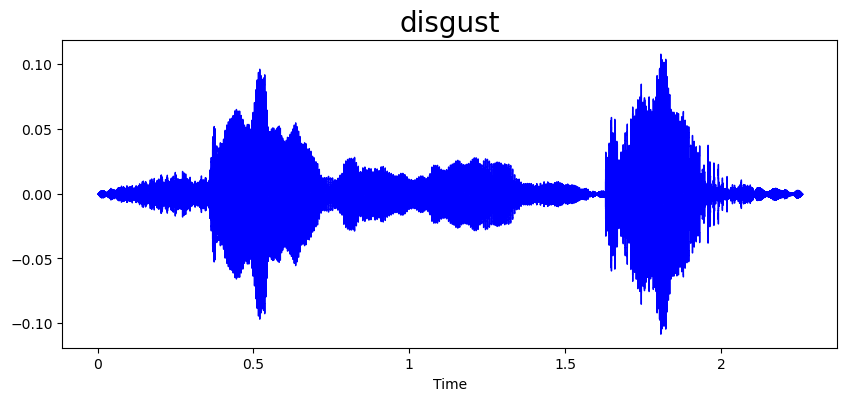

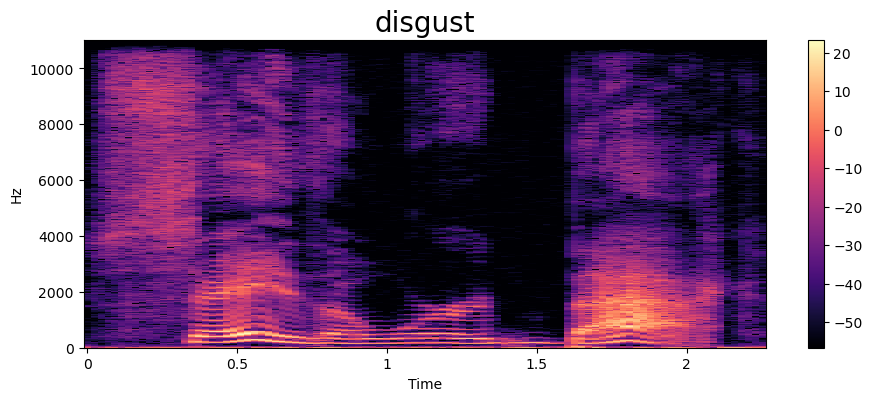

In [35]:
emotion = 'disgust'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]  

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


**Waveplot and Spectrogram: Angry Emotion**

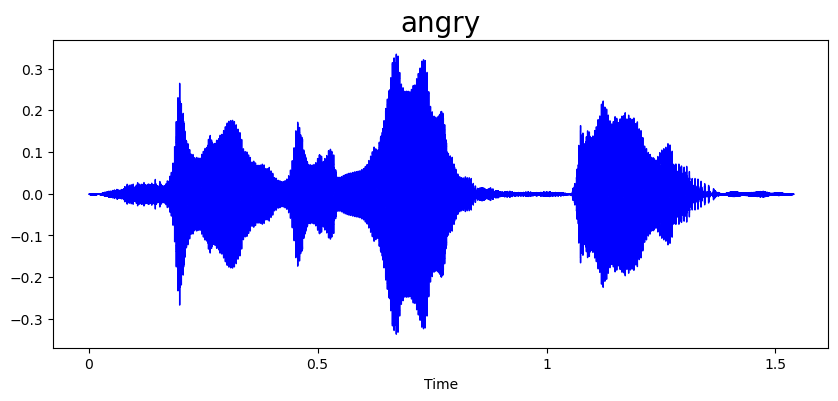

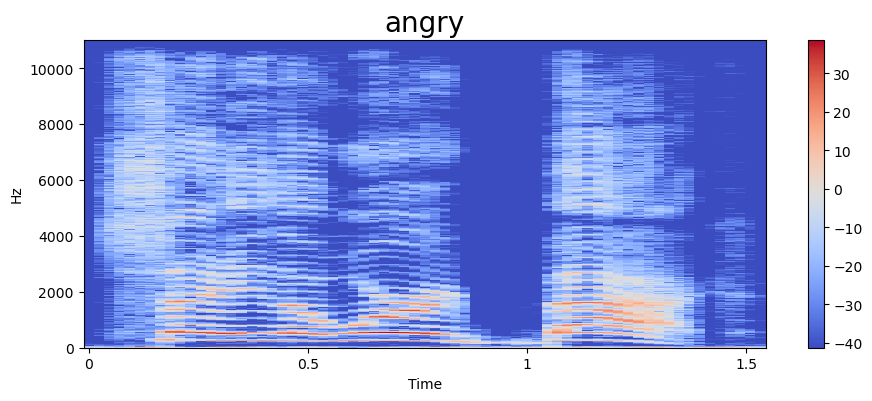

In [36]:
emotion = 'angry'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]  

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


**Waveplot and Spectrogram: Neutral Emotion**

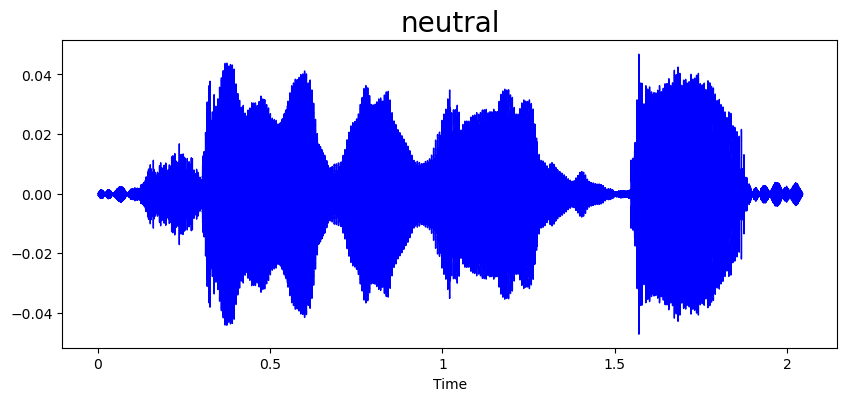

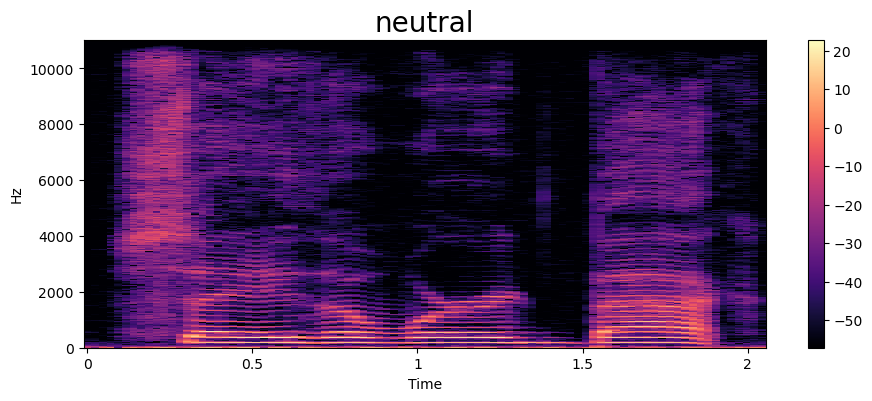

In [37]:
emotion = 'neutral'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]  

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


**Waveplot and Spectrogram: Pleasantly surprised emotion**

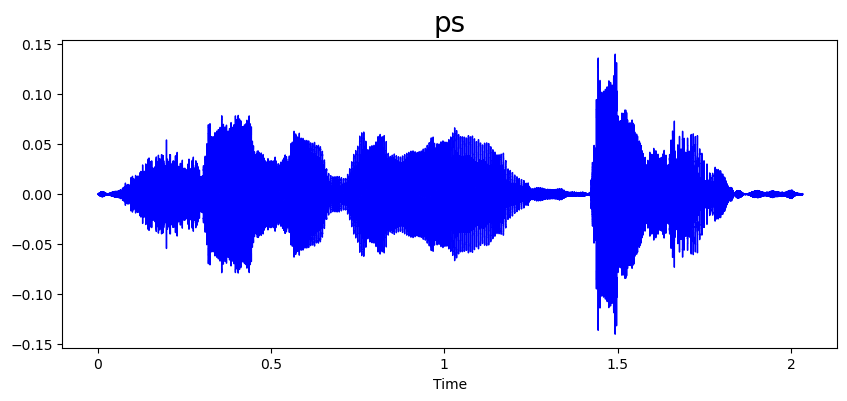

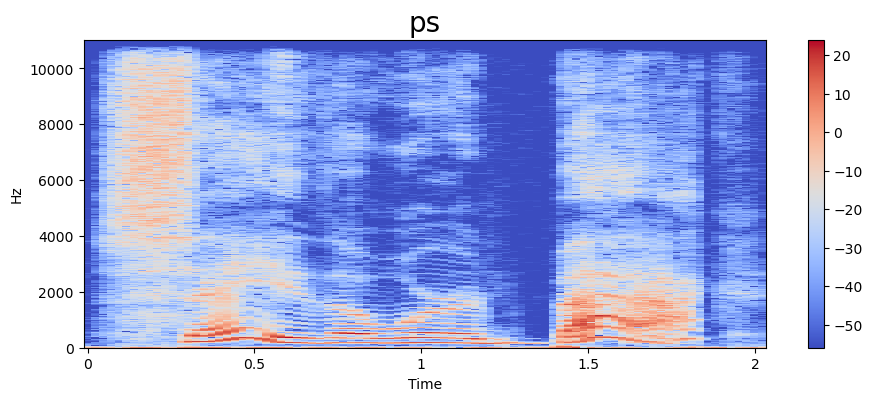

In [38]:
emotion = 'ps'
row = emotion_df_wav[emotion_df_wav['Emotion'] == emotion].iloc[0]  

data, sampling_rate = librosa.load(row['File Path'])

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)


### Data Pre-processing and Feature Extraction

In this section we will extract acoustic features from the preprocessed audio data that captures the key characteristics related to the emotion, such as pitch,intensity and the spectoral properties. We will also perform some audio preprocessing:

-`Noise Reduction`:  To enhance the clarity of the speech signal by minimizing unwanted disturbances.
 
-`Normalizaton`: Consistent Amplitude: Normalization ensures that the amplitude of the audio signal remains within a consistent range

In [39]:
def extract_features(file_path):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)
    # Apply normalization
    audio = librosa.util.normalize(audio)
    # Extract MFCCs (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # Calculate pitch
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitch = np.mean(pitches)
    
    # Calculate energy
    energy = np.mean(librosa.feature.rms(y=audio))
    
    # Calculate spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr))
    
    return mfccs, pitch, energy, spectral_centroid, spectral_bandwidth, spectral_contrast

The function above extracts various audio features from an audio file and  includes MFCCs, pitch, energy, and spectral features,  this provides a comprehensive representation of the audio characteristics in our dataframe.

#### Audio Feature Extraction Steps:

1. **Load Audio File**:
   - The code uses the `librosa.load()` function to load the audio file specified by `file_path`.
   - It returns the audio waveform `y` and the sample rate `sr`.

2. **Extract MFCCs (Mel-Frequency Cepstral Coefficients)**:
   - MFCCs are extracted using the `librosa.feature.mfcc()` function.
   - `n_mfcc=13` specifies the number of MFCC coefficients to extract.

3. **Calculate Pitch**:
   - Pitch is calculated using the `librosa.piptrack()` function.
   - The mean pitch value is calculated from the obtained pitches.

4. **Calculate Energy**:
   - Energy is calculated using the root mean square (RMS) of the audio signal.
   - It's calculated using `librosa.feature.rms()`.

5. **Calculate Spectral Features**:
   - Spectral Centroid, Spectral Bandwidth, and Spectral Contrast are calculated using `librosa.feature` functions.
   - They represent different aspects of the frequency content of the audio signal.

In [40]:
audio_features = []
max_length = 0  # Track the maximum length of MFCC arrays

for file_path in emotion_df_wav['File Path']:
    mfccs, pitch, energy, spectral_centroid, spectral_bandwidth, spectral_contrast = extract_features(file_path)
    
    # Flatten MFCCs to ensure consistent shape
    mfccs_flat = mfccs.flatten()
    
    # Update max_length if necessary
    max_length = max(max_length, mfccs_flat.shape[0])
    
    # Combine all other features into a single 1D array
    features_combined = np.hstack((mfccs_flat, pitch, energy, spectral_centroid, spectral_bandwidth, spectral_contrast))
    
    audio_features.append(features_combined)

**Flattening and Combining Features**: MFCCs are flattened to ensure a consistent shape. All features are combined into a single 1D array for further analysis. The arrays represents the combined features for a specific audio file.

In [41]:
# Pad MFCC arrays to ensure consistent shapes
max_length = max(len(features) for features in audio_features)

padded_audio_features = []
for features in audio_features:
    # Calculate the amount of padding needed
    padding_width = max_length - len(features)
    # Pad the features array with zeros to match the maximum length
    padded_features = np.pad(features, ((0, padding_width)), mode='constant')
    padded_audio_features.append(padded_features)

# Convert the list of arrays to a 2D NumPy array
padded_audio_features_array = np.array(padded_audio_features)

print(padded_audio_features_array.shape)  # Display the shape of the padded array
# print(padded_audio_features_array[:5])     # Display the first 5 elements of the padded array

def preprocess_emotional_dataframe(df):
    # Make a copy of the DataFrame to store processed data
    df_processed = df.copy()
    # Add a column to store processed features
    df_processed['Processed Features'] = None
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        file_path = row['File Path']
        processed_features = padded_audio_features_array
        df_processed.at[index, 'Processed Features'] = processed_features
    return df_processed

preprocessed_df = preprocess_emotional_dataframe(emotion_df_wav)


(2800, 3697)


**Padding MFCC Arrays**: MFCC arrays are padded with zeros to ensure consistent shapes across all arrays for further processing.

### Labeling
   Labeling is a crucial step in the field of machine learning and data analysis, and it holds significant importance for several reasons:
    " `supervised learning`, `model evaluation` and `training`, `generalization` and `deployment` 

In [42]:
def label_emotion(row):
    emotion = row['Emotion']
    if emotion == 'angry':
        return 'Negative'
    elif emotion == 'disgust':
        return 'Negative'
    elif emotion == 'fear':
        return 'Negative'
    elif emotion == 'sad':
        return 'Negative'
    elif emotion == 'happy':
        return 'Positive'
    elif emotion == 'neutral':
        return 'Neutral'
    else:
        return 'Unknown'

# Apply label_emotion function to create a new column 'Label'
def label_dataframe(df):
    labeled_df = df.copy()
    labeled_df['Label'] = labeled_df.apply(label_emotion, axis=1)
    return labeled_df

# Apply label_dataframe function to the preprocessed DataFrame
labeled_df = label_dataframe(preprocessed_df)

# Display the labeled DataFrame
print(labeled_df.head(10))

                 ID             File Name  Emotion  \
0    angry_693c0b77    OAF_back_angry.wav    angry   
1  disgust_b9f2e115  OAF_back_disgust.wav  disgust   
2     fear_a7d34d00     OAF_back_fear.wav     fear   
3    happy_5820924d    OAF_back_happy.wav    happy   
4  neutral_753bdcf1  OAF_back_neutral.wav  neutral   
5       ps_6e9d4ea5       OAF_back_ps.wav       ps   
6      sad_fd4be1af      OAF_back_sad.wav      sad   
7    angry_309a4d59     OAF_bar_angry.wav    angry   
8  disgust_d1c4fca7   OAF_bar_disgust.wav  disgust   
9     fear_b2d75d75      OAF_bar_fear.wav     fear   

                              File Path  \
0    dataverse_files\OAF_back_angry.wav   
1  dataverse_files\OAF_back_disgust.wav   
2     dataverse_files\OAF_back_fear.wav   
3    dataverse_files\OAF_back_happy.wav   
4  dataverse_files\OAF_back_neutral.wav   
5       dataverse_files\OAF_back_ps.wav   
6      dataverse_files\OAF_back_sad.wav   
7     dataverse_files\OAF_bar_angry.wav   
8   dataverse_file

### Baseline Model

In [43]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary sets
train_data, temp_data = train_test_split(padded_audio_features_array, test_size=0.2, random_state=42)

# Further split the temporary data into validation and testing sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Display the shapes of the datasets
print("Training data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (2240, 3697)
Validation data shape: (280, 3697)
Testing data shape: (280, 3697)


**Splitting the Data**: The data is split into training, validation, and testing sets using `train_test_split` from `sklearn.model_selection`.

**Displaying Data Shapes**: The shapes of the training, validation, and testing datasets are displayed for reference.

This section sets the stage for training machine learning models using the extracted audio features.